In my previous notebooks, I run `tractor` in an iterative way: add several sources each time and have the model optimized. But I noticed that in the `legacypipe`, Dustin Lang runs `tractor` on a [blob-by-blob basis](https://github.com/legacysurvey/legacypipe/blob/main/doc/outline.md#fitting): in order of brightness, 

Model selection when DECaLS tractor catalog is not available: https://github.com/legacysurvey/legacypipe/blob/main/doc/outline.md#model-selection, https://github.com/legacysurvey/legacypipe/blob/6d1a92f8462f4db9360fb1a68ef7d6c252781027/py/legacypipe/oneblob.py#L605


In [106]:
from tractor import Catalog
from tractor.dense_optimizer import ConstrainedDenseOptimizer

## This notebook demonstrate how to model the 10 lucky dwarf galaxies in HSC images using [`the tractor`](https://github.com/dstndstn/tractor). 
- `tractor` asks for flux, shape, and morphology type (exponential or Sersic) to initialize a model. In this notebook, the flux and shape are taken from the output of Source Extractor Python (`sep`). The morphology type is taken from the DECaLS catalog (by cross-matching `sep` output catalog with DECaLS catalog). 

- Need help when installing `the tractor`? Check [this website](https://astrojacobli.github.io/blog/2018/10/Macbook-for-Astronomy#install-the-tractor).
- You need to install [`kuaizi`](https://github.com/AstroJacobLi/kuaizi) to run this notebook. `kuaizi` contains some handy tools I often use.

In [9]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
## Load catalog and images
obj_cat = Table.read('/Users/jiaxuanli/Research/Merian/cosmos_test_1/cosmos_test_1-2021-02-04.fits')

In [11]:
obj_cat['name']

<Column name='name' dtype='bytes18' length=10>
s18a_wide_226984_y
s18a_wide_233677_y
s18a_wide_238189_y
s18a_wide_240617_y
s18a_wide_255782_y
s18a_wide_265172_y
s18a_wide_274464_y
s18a_wide_275931_y
s18a_wide_277061_y
s18a_wide_301016_y

In [12]:
import scarlet # I only use this package to generate RGB image for display purpose.
## Initialize `unagi`
from unagi import hsc, config
from unagi import plotting
from unagi import task, catalog

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /Users/jiaxuanli/Research/Packages/unagi/unagi/data/pdr2_wide/pdr2_wide_tables.fits


## Let's fit a dwarf step by step

In [51]:
channels = 'grizy'

obj = obj_cat[0]
obj_id = obj['name'].lstrip('s18a_wide').rstrip('_y')

cutout = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}.fits'
    ) for filt in channels
]
psf_list = [
    fits.open(
        f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}_psf.fits'
    ) for filt in channels
]

coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

In [52]:
# Reconstruct data
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

images = np.array([hdu[1].data for hdu in cutout])
w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
filters = list(channels)
weights = 1 / np.array([hdu[3].data for hdu in cutout])
psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
# `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy

(-0.5, 178.5, -0.5, 178.5)

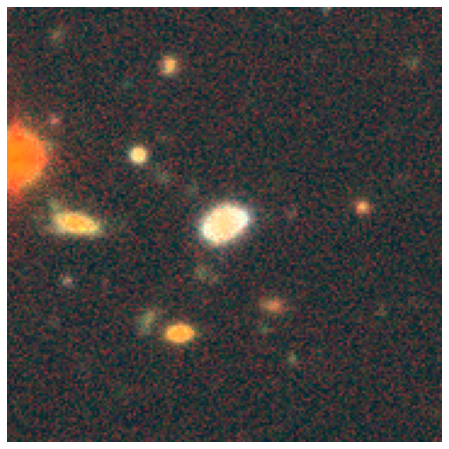

In [53]:
# Visualize our data, optional
import scarlet

stretch = 1
Q = 0.5
channel_map = scarlet.display.channels_to_rgb(len(channels))

img_rgb = scarlet.display.img_to_rgb(
    data.images,
    norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
    channel_map=channel_map)

fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(img_rgb, origin='lower')
plt.axis('off')

In [54]:
## Use Source Extractor to deblend and initialize `tractor`
from kuaizi.tractor.utils import makeCatalog

filt = 'i'
layer_ind = channels.index(filt)

    Detected 18 objects


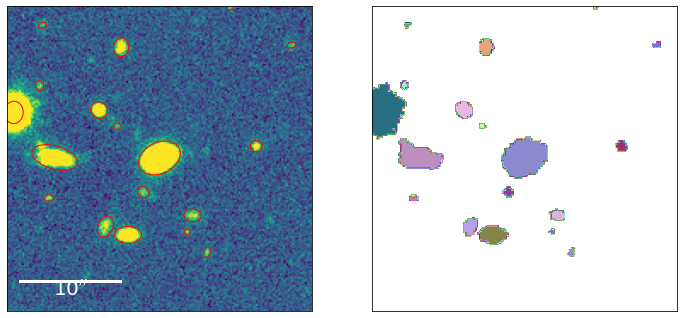

In [55]:
# typical Source Extractor Python (SEP) run, with relatively-low sigma
obj_cat_sep, segmap_sep = makeCatalog(
    [data],
    layer_ind=layer_ind,
    lvl=2.5,
    mask=None,
    method='vanilla',
    convolve=False, 
    match_gaia=False,
    show_fig=True,
    visual_gaia=False,
    b=32,
    f=3,
    pixel_scale=0.168,
    minarea=5,
    deblend_nthresh=48,
    deblend_cont=0.005,
    sky_subtract=True)

In [56]:
## Download DECaLS tractor catalogs and match SEP detection with the tractor catalog
from astropy.table import vstack
from astropy.coordinates import match_coordinates_sky

# DR9 brick catalog, downloaded from https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/
bricks_cat = Table.read(
    '/Users/jiaxuanli/Research/Merian/merian_tractor/survey-bricks-dr9.fits.gz', format='fits')  
# Match bricks with SEP detection
bricks_corr = SkyCoord(
    ra=np.array(bricks_cat['RA']) * u.degree,
    dec=np.array(bricks_cat['DEC']) * u.degree)
detect_coor = SkyCoord(
    ra=obj_cat_sep['ra'] * u.degree, dec=obj_cat_sep['dec'] * u.degree)

to_download = bricks_cat[np.unique(
    match_coordinates_sky(detect_coor, bricks_corr)[0])]
bricknames = to_download['BRICKNAME'].data.astype(
    str)  # in case that there are more than one `tractor` file
print('We need bricks: ', bricknames)
# `bricknames` are tractor files we need.

We need bricks:  ['1496p015' '1496p017']


In [58]:
# Download tractor catalog of the corresponding brick
# This could be time-consuming, depending on internet connection. 
# Maybe we can work on a cluster (such as NERSC or `tiger`) where these `tractor catalogs` can be pre-downloaded.  
tractor_cat = kuaizi.download.download_decals_tractor_catalog(bricknames, layer='dr9', overwrite=False)

https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p015.fits ./tractor-1496p015.fits


./tractor-1496p015.fits: 11.1MB [00:10, 1.01MB/s]                            


# Downloading ./tractor-1496p015.fits finished! 
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p017.fits ./tractor-1496p017.fits


./tractor-1496p017.fits: 10.3MB [01:11, 143kB/s]                             


# Downloading ./tractor-1496p017.fits finished! 


In [161]:
# Match these galaxies with DECaLS tractor file and get their morphology types
decals_corr = SkyCoord(
    ra=np.array(tractor_cat['ra']) * u.degree,
    dec=np.array(tractor_cat['dec']) * u.degree)
detect_coor = SkyCoord(ra=obj_cat_sep['ra'] * u.degree, dec=obj_cat_sep['dec'] * u.degree)

temp = tractor_cat[match_coordinates_sky(detect_coor, decals_corr)[0]]
for columns in temp.columns:
    obj_cat_sep.add_column(temp[columns], rename_duplicate=True)
obj_cat_sep.sort('flux', reverse=True)
obj_cat_sep

<Table length=18>
obj_type index         x          ...  shape_e2_1 shape_e2_ivar_1
                                  ...                            
 object  int64      float64       ...   float32       float32    
-------- ----- ------------------ ... ----------- ---------------
    None     0  3.354599942604728 ...         0.0             0.0
    None     1  89.03520985792889 ... -0.24712697       26489.371
    None     2 27.422886192695454 ...  0.21498318       1461.1251
    None     3  70.56993484511352 ...         0.0             0.0
    None     4 53.565032026913016 ...         0.0             0.0
    None     5   66.4777264665977 ...         0.0             0.0
    None     6  57.29800885715483 ...         0.0             0.0
    None     7 108.47676709395266 ... -0.24712697       26489.371
    None     8  145.9507882675506 ...         0.0             0.0
    None     9  79.63529134169502 ... -0.24712697       26489.371
    None    10  18.56736512419772 ...         0.0             0.0
    None    11 24.019588494510206 ...    0.210268       1455.7157
    None    12 116.89154207378894 ...         0.0             0.0
    None    13  166.7174763760359 ...         0.0             0.0
    None    14  64.19575332446679 ...         0.0             0.0
    None    15 105.31460472735627 ...         0.0             0.0
    None    16 20.257497395396417 ...         0.0             0.0
    None    17 130.74425149774973 ...         0.0             0.0

In [207]:
catalog_c = SkyCoord(obj_cat_sep['ra'], obj_cat_sep['dec'], unit='deg')
dist = coord.separation(catalog_c)
cen_obj_ind = np.argsort(dist)[0]
cen_obj = obj_cat_sep[cen_obj_ind]
### Add a "target" column to indicate which object is the target galaxy ###
obj_cat_sep['target'] = np.zeros(len(obj_cat_sep), dtype=int)
obj_cat_sep['target'][cen_obj_ind] = 1

print(f'# Type of central object is {cen_obj["type"]}')
print(f'# Total number of objects: {len(obj_cat_sep)}')

# Type of central object is SER
# Total number of objects: 18


In [61]:
#obj_cat_sex['type'][obj_cat_sex['type'] == 'PSF'] = 'REX'

 - Now you have 2 sources
 - Now you have 18 sources


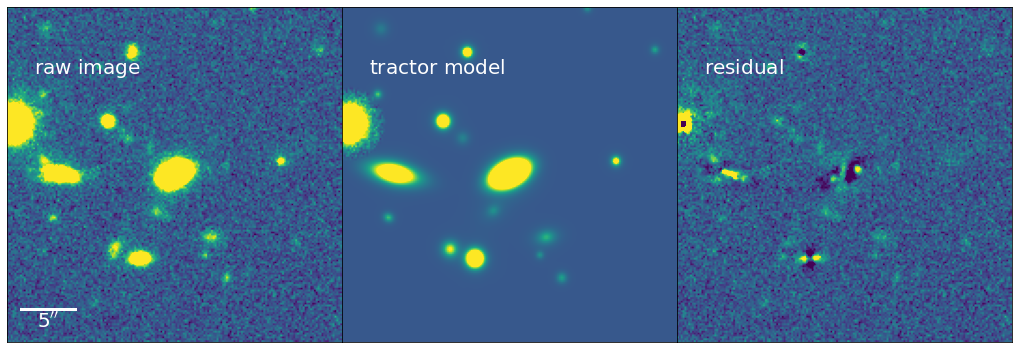

   The chi-square is 7.212782e-05


In [214]:
from tractor import PixelizedPSF
from kuaizi.tractor.utils import tractor_iteration
psf_obj = PixelizedPSF(data.psfs[layer_ind]) # Construct PSF

sources, trac_obj, fig = tractor_iteration(
    obj_cat_sep,
    data.wcs,
    data.images[layer_ind],
    data.weights[layer_ind],
    psf_obj,
    kuaizi.HSC_pixel_scale,
    shape_method='decals',
    freeze_dict={'pos': True, 'shape': True, 'sersicindex': False},
    kfold=2, # how many rounds 
    first_num=cen_obj_ind + 1, # the number of objects for the first round
    fig_name='test')

In [218]:
list(zip(trac_obj.catalog.getParamNames(), trac_obj.catalog.getParams()))

[('source0.pos.x', 2.877041382302569),
 ('source0.pos.y', 116.16503955108679),
 ('source0.brightness.Flux', 3600.8978290753007),
 ('source1.brightness.Flux', 393.70081374114926),
 ('source1.sersicindex.SersicIndex', 0.6705316141755449),
 ('source2.pos.x', 27.595864439222503),
 ('source2.pos.y', 89.59458767933982),
 ('source2.brightness.Flux', 152.89023284676577),
 ('source2.shape.re', 1.3112971800496904),
 ('source2.shape.e1', -0.4556642095029883),
 ('source2.shape.e2', -0.21602146777335152),
 ('source3.pos.x', 70.57363442838638),
 ('source3.pos.y', 44.16537325495169),
 ('source3.brightness.Flux', 76.79338246496462),
 ('source3.shape.re', 0.33177464427857833),
 ('source4.pos.x', 53.555969591598064),
 ('source4.pos.y', 117.54273366566997),
 ('source4.brightness.Flux', 39.08779191753395),
 ('source4.shape.re', 0.23007150450387012),
 ('source5.pos.x', 66.49613299977824),
 ('source5.pos.y', 154.42195277589582),
 ('source5.brightness.Flux', 20.199251879035167),
 ('source6.pos.x', 57.2889239

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

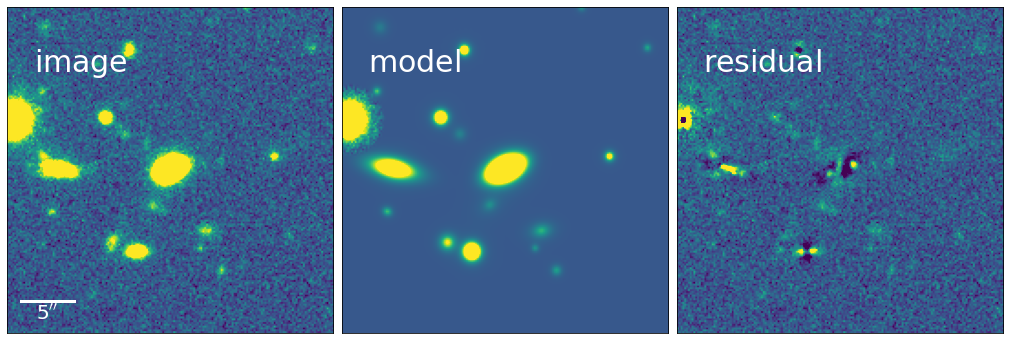

In [277]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

with HiddenPrints():
    trac_mod = trac_obj.getModelImage(0, srcs=sources)

kuaizi.display.display_multiple(
    [data.images[layer_ind], trac_mod, data.images[layer_ind] - trac_mod],
    text=['image', 'model', 'residual'],
    ax=axes,
    scale_bar_y_offset=0.4)

## I've incorporate the above steps into `kuaizi.tractor.utils.tractor_sep` function.

In [278]:
from kuaizi.tractor.utils import tractor_hsc_sep

In [279]:
channels = 'grizy'

In [280]:
# Save all the files to './sep-decals'
import os
os.chdir('./sep-decals/')

### `s18a_wide_226984` g-band
    Detected 11 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p015.fits ./tractor-1496p015.fits
!!!The file "./tractor-1496p015.fits" already exists!!!
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p017.fits ./tractor-1496p017.fits
!!!The file "./tractor-1496p017.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 11
# Central object index in g-band: 1
 - Now you have 2 sources
 - Now you have 6 sources
   The chi-square is 3.558435e-05
 - Now you have 10 sources


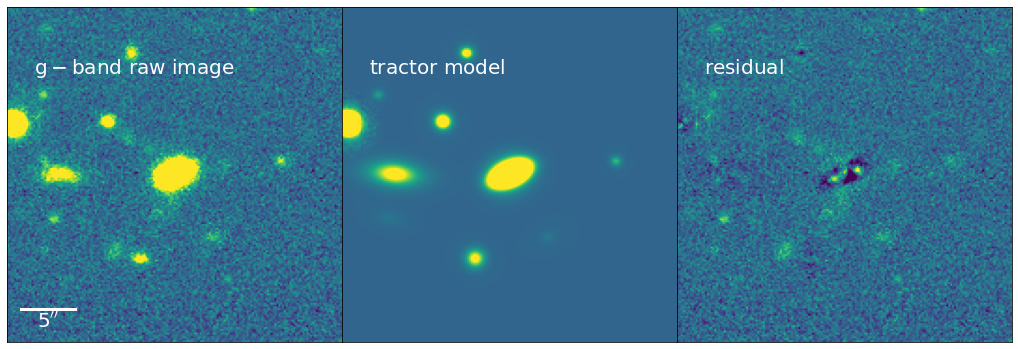

   The chi-square is 3.5099536e-05
### `s18a_wide_226984` r-band
    Detected 11 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p015.fits ./tractor-1496p015.fits
!!!The file "./tractor-1496p015.fits" already exists!!!
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p017.fits ./tractor-1496p017.fits
!!!The file "./tractor-1496p017.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 11
# Central object index in r-band: 1
 - Now you have 2 sources
 - Now you have 6 sources
   The chi-square is 2.56992e-05
 - Now you have 10 sources


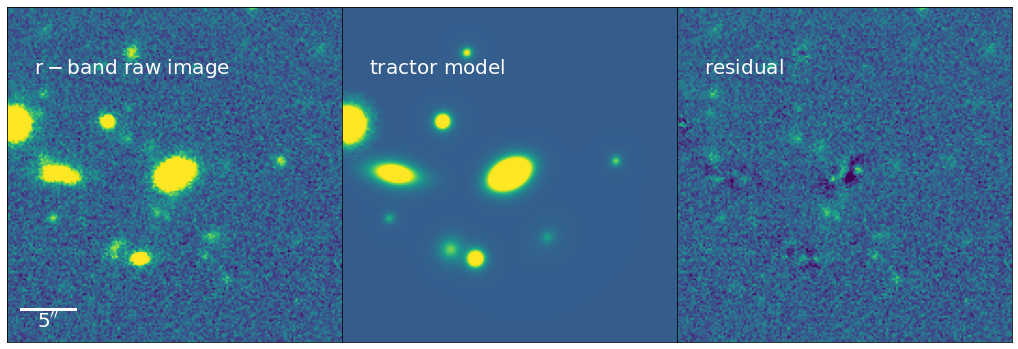

   The chi-square is 2.4915471e-05
### `s18a_wide_226984` i-band
    Detected 18 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p015.fits ./tractor-1496p015.fits
!!!The file "./tractor-1496p015.fits" already exists!!!
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p017.fits ./tractor-1496p017.fits
!!!The file "./tractor-1496p017.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 18
# Central object index in i-band: 1
 - Now you have 2 sources
 - Now you have 10 sources
   The chi-square is 7.200604e-05
 - Now you have 18 sources


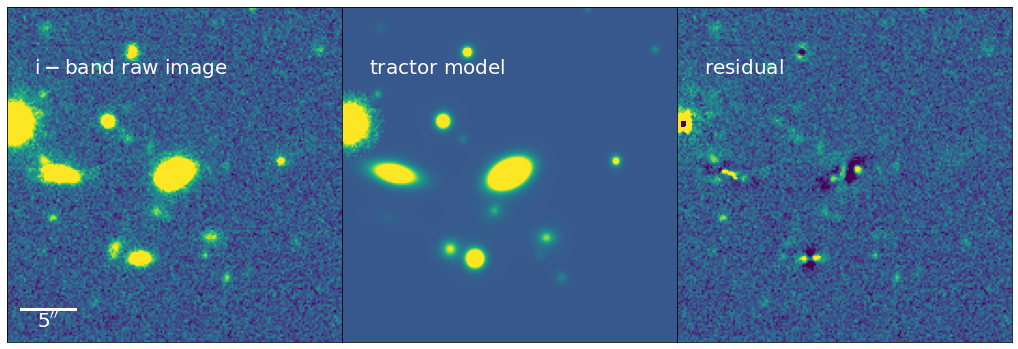

   The chi-square is 7.198061e-05
### `s18a_wide_226984` z-band
    Detected 9 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p015.fits ./tractor-1496p015.fits
!!!The file "./tractor-1496p015.fits" already exists!!!
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p017.fits ./tractor-1496p017.fits
!!!The file "./tractor-1496p017.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 9
# Central object index in z-band: 1
 - Now you have 2 sources
 - Now you have 5 sources
   The chi-square is 6.76632e-05
 - Now you have 8 sources


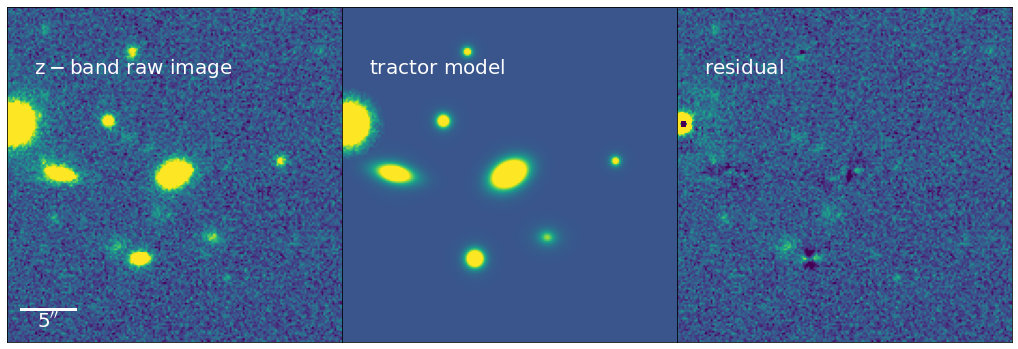

   The chi-square is 6.7529545e-05
### `s18a_wide_226984` y-band
    Detected 8 objects
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p015.fits ./tractor-1496p015.fits
!!!The file "./tractor-1496p015.fits" already exists!!!
https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/149/tractor-1496p017.fits ./tractor-1496p017.fits
!!!The file "./tractor-1496p017.fits" already exists!!!
# Type of the central object is SER
# Total number of objects: 8
# Central object index in y-band: 1
 - Now you have 2 sources
 - Now you have 5 sources
   The chi-square is 5.182274e-05
 - Now you have 8 sources


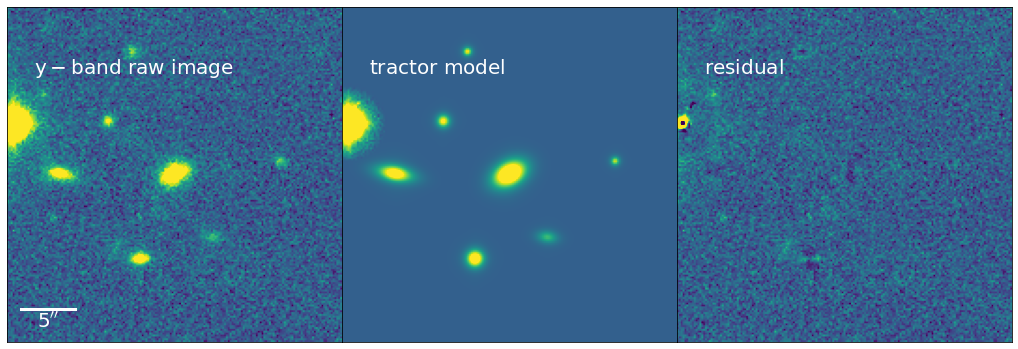

   The chi-square is 5.163725e-05


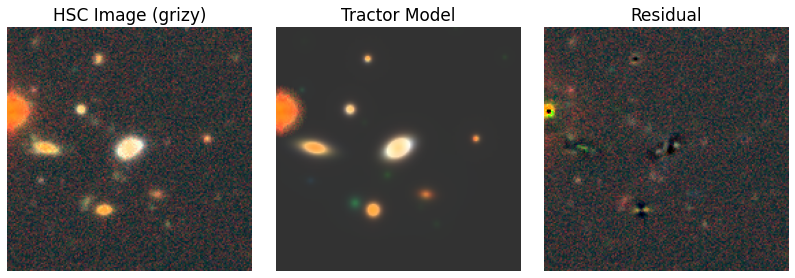

In [291]:
for obj in obj_cat[:1]:
    obj_name = obj['name'].rstrip('_y')
    obj_id = obj_name.lstrip('s18a_wide')
    
    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    cutout = [
        fits.open(
            f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}.fits'
        ) for filt in channels
    ]
    psf_list = [
        fits.open(
            f'/Users/jiaxuanli/Research/Merian/cosmos_test_1/1/{obj_id}/hsc/s18a_wide_{obj_id}_{filt}_psf.fits'
        ) for filt in channels
    ]

    # Reconstruct data
    from kuaizi.detection import Data
    from kuaizi.utils import padding_PSF

    images = np.array([hdu[1].data for hdu in cutout])
    w = wcs.WCS(cutout[0][1].header) # note: all bands share the same WCS here
    filters = list(channels)
    weights = 1 / np.array([hdu[3].data for hdu in cutout])
    psf_pad = padding_PSF(psf_list) # Padding PSF cutouts from HSC
    data = Data(images=images, weights=weights, wcs=w, psfs=psf_pad, channels=channels)
    # `data` is an Python object which contains all the information (image, psf, variance, wcs, etc.) about the galaxy
    
    
    # Start fitting
    model_dict = {}
    for filt in channels:
        model_dict[filt] = tractor_hsc_sep(obj, filt, channels, data, 
                                           freeze_dict={'pos': True, 'shape': False, 'sersicindex': False},
                                           brick_file='/Users/jiaxuanli/Research/Merian/merian_tractor/survey-bricks-dr9.fits.gz',
                                           verbose=False)
    
    with open(obj_name + '_sep_tractor.pkl', 'wb') as f:
        pickle.dump(model_dict, f)
        
    ### Make figures into a PDF file (slow)
    from fpdf import FPDF
    pdf = FPDF()
    pdf.add_page()
    for k, image in enumerate([obj_name + '_sep_tractor_' + filt + '.png' for filt in channels]):
        pdf.image(image, 21, 11 + k * 55, 167, 55)
    pdf.output(obj_name + "_sep_tractor.pdf", "F")

    # Visualize our model
    from kuaizi.tractor.utils import HiddenPrints
    with HiddenPrints():
        model_img = np.asarray([model_dict[key].getModelImage(0) for key in channels])

    stretch = 1
    Q = 0.5
    channel_map = scarlet.display.channels_to_rgb(len(channels))

    img_rgb = scarlet.display.img_to_rgb(
        data.images,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    model_rgb = scarlet.display.img_to_rgb(
        model_img,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    res_rgb = scarlet.display.img_to_rgb(
        data.images - model_img,
        norm=scarlet.display.AsinhMapping(minimum=-0.2, stretch=stretch, Q=Q),
        channel_map=channel_map)

    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(14, 8))
    ax1.imshow(img_rgb, origin='lower')
    ax2.imshow(model_rgb, origin='lower')
    ax3.imshow(res_rgb, origin='lower')

    for ax in [ax1, ax2, ax3]:
        ax.axis('off')

    ax1.set_title('HSC Image (grizy)', fontsize=17)
    ax2.set_title('Tractor Model', fontsize=17)
    ax3.set_title('Residual', fontsize=17)

    plt.subplots_adjust(wspace=0.1)
    plt.savefig(obj_name + '_sep_tractor_rgb.png', 
                bbox_inches='tight', 
                metadata={'Comment': 'Each filter is fit seperately, using the Source Extractor + DECaLS catalog in each filter'})
    

    #clear_output()
    #plt.close()

In [292]:
#### As you can see below, the target galaxy (source1) doesn't have `pos` attribute, meaning that `pos` is frozen!
list(zip(model_dict['r'].catalog.getParamNames(), model_dict['r'].catalog.getParams()))

[('source0.pos.x', 2.862535733634261),
 ('source0.pos.y', 116.12401756984157),
 ('source0.brightness.Flux', 1122.6435600540703),
 ('source1.brightness.Flux', 334.5008425577006),
 ('source1.shape.re', 1.012051796906547),
 ('source1.shape.e1', -0.18039493078676205),
 ('source1.shape.e2', 0.2402978485041529),
 ('source1.sersicindex.SersicIndex', 0.7275533662768005),
 ('source2.pos.x', 27.719822941239734),
 ('source2.pos.y', 89.4538720779365),
 ('source2.brightness.Flux', 126.68759519255573),
 ('source2.shape.re', 1.3997112556956826),
 ('source2.shape.e1', -0.46933513867172794),
 ('source2.shape.e2', -0.17316421669954624),
 ('source3.pos.x', 70.88341177093008),
 ('source3.pos.y', 44.111127760128674),
 ('source3.brightness.Flux', 44.29181681035188),
 ('source3.shape.re', 0.32042896365113177),
 ('source4.pos.x', 53.321485810853765),
 ('source4.pos.y', 117.38165700299962),
 ('source4.brightness.Flux', 39.01834059762077),
 ('source4.shape.re', 0.22700155375868689),
 ('source5.pos.x', 57.462815

## Blob-by-blob

In [155]:
from tractor import NullWCS, NullPhotoCal, ConstantSky
from tractor.galaxy import GalaxyShape, DevGalaxy, ExpGalaxy, CompositeGalaxy
from tractor.psf import Flux, PixPos, PointSource, PixelizedPSF, Image, Tractor
from tractor.ellipses import EllipseE
import copy
from kuaizi.tractor.utils import add_tractor_sources, HiddenPrints

In [ ]:
from tractor import PixelizedPSF
from kuaizi.tractor.utils import tractor_iteration
psf_obj = PixelizedPSF(data.psfs[layer_ind]) # Construct PSF

sources, trac_obj, fig = tractor_iteration(
    obj_cat_sep,
    data.wcs,
    data.images[layer_ind],
    data.weights[layer_ind],
    psf_obj,
    kuaizi.HSC_pixel_scale,
    shape_method='decals',
    freeze_dict={'pos': True, 'shape': True, 'sersicindex': False}, # whether freeze positions of objects during fitting
    kfold=2, # how many rounds 
    first_num=cen_obj_ind + 1, # the number of objects for the first round
    fig_name='test')

In [238]:
freeze_dict = {'pos': True, 'shape': True, 'sersicindex': False}

In [274]:
blob_sources = []
if 'target' in obj_cat_sep.colnames:
    target_index = np.where(obj_cat_sep['target'] == 1)[0][0]

with HiddenPrints():
    for i, obj in enumerate(obj_cat_sep):
        total_sources = copy.deepcopy(sources)
        total_sources.pop(i)
        trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=total_sources)
        residual = data.images[layer_ind] - trac_mod_opt
        src = add_tractor_sources(Table(obj), None, data.wcs, shape_method='decals')
        # Free parameter for our target galaxy
        if obj['target'] == 1:
            [src[0].freezeParam(key) for key in freeze_dict if key in src[0].namedparams and freeze_dict[key] is True]
        
        tim = Image(data=residual,
                    invvar=data.weights[layer_ind],
                    psf=psf_obj,
                    wcs=NullWCS(pixscale=kuaizi.HSC_pixel_scale),
                    sky=ConstantSky(0.0),
                    photocal=NullPhotoCal()
                    )
        trac_obj = Tractor([tim], src)
        trac_obj.freezeParam('images')
        trac_obj.optimize_loop()
        blob_sources.append(src[0])
        print(f'# Progress: {i} / {len(obj_cat_sep)}')
        
        
tim = Image(data=data.images[layer_ind],
            invvar=data.weights[layer_ind],
            psf=psf_obj,
            wcs=NullWCS(pixscale=kuaizi.HSC_pixel_scale),
            sky=ConstantSky(0.0),
            photocal=NullPhotoCal()
            )
trac_obj = Tractor([tim], blob_sources)

with HiddenPrints():
    trac_mod_opt = trac_obj.getModelImage(
        0, minsb=0.)
    
print(
    '   The chi-square is',
    np.sqrt(
        np.mean(np.square((data.images[layer_ind] - trac_mod_opt).flatten()))) / np.sum(data.images[layer_ind]))

   The chi-square is 7.319403e-05


In [275]:
with HiddenPrints():
    trac_obj.optimize_loop()
    trac_mod_opt = trac_obj.getModelImage(
        0, minsb=0.)
    
print(
    '   The chi-square is',
    np.sqrt(
        np.mean(np.square((data.images[layer_ind] - trac_mod_opt).flatten()))) / np.sum(data.images[layer_ind]))  

   The chi-square is 7.319403e-05


Given a noise model of the instrument and assuming pixelwise independent noise, the log-likelihood is just the negative chi-squared difference: (image - model) / noise.

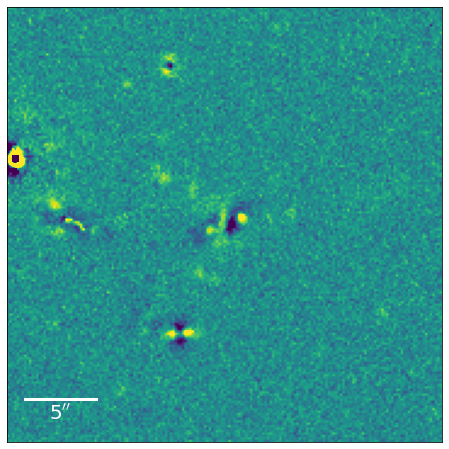

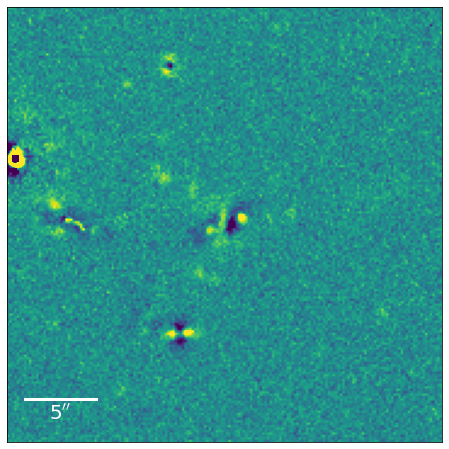

In [276]:
display_single(data.images[layer_ind] - trac_mod_opt)

In [ ]:


if len(obj_cat) < 1:
    raise ValueError(
        "The length of `obj_cat` is less than 1. Please check your catalog!")
elif len(obj_cat) == 1:
    # when there's only one object, you don't need to run Tractor for several rounds.
    kfold = 1
else:
    step = int((len(obj_cat) - first_num) / (kfold - 1))

if freeze_dict is None:
    freeze_dict = {}

for i in range(kfold):
    if i == 0:
        obj_small_cat = obj_cat[:first_num]
        sources = add_tractor_sources(
            obj_small_cat, None, w, shape_method=shape_method)
    else:
        obj_small_cat = obj_cat[first_num +
                                step * (i - 1): first_num + step * (i)]
        sources = add_tractor_sources(
            obj_small_cat, sources, w, shape_method=shape_method)

    with HiddenPrints():
        for key in freeze_dict:
            if freeze_dict[key] is True:
                [src.freezeParam(key) for src in sources[:1] if key in src.namedparams]
                # `src.namedparams` indicates the name of available parameters for this source
                # We may only want to freeze the params for the target galaxy??? Don't need to freeze for all.
        tim = Image(data=img_data,
                    invvar=invvar,
                    psf=psf_obj,
                    wcs=NullWCS(pixscale=pixel_scale),
                    sky=ConstantSky(0.0),
                    photocal=NullPhotoCal()
                    )
        trac_obj = Tractor([tim], sources)
        trac_obj.freezeParam('images')
        trac_obj.optimize_loop()
    #     # Take several linearized least squares steps
    #     for i in range(20):
    #         dlnp, X, alpha = trac_obj.optimize()
    #         if dlnp < 1e-5:
    #             break
    # print(dlnp, i)

    ########################
    plt.rc('font', size=20)
    if i % 2 == 1 or i == (kfold - 1):
        fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 8))

        with HiddenPrints():
            trac_mod_opt = trac_obj.getModelImage(
                0, minsb=0., srcs=sources[:])

        if band_name is None:
            _ = kuaizi.display.display_multiple(
                [img_data, trac_mod_opt, img_data - trac_mod_opt],
                text=['raw\ image', 'tractor\ model', 'residual'],
                ax=[ax1, ax2, ax3], scale_bar_y_offset=0.4, text_fontsize=20)
        else:
            _ = kuaizi.display.display_multiple(
                [img_data, trac_mod_opt, img_data - trac_mod_opt],
                text=[f'{band_name}-band\ raw\ image',
                      'tractor\ model', 'residual'],
                ax=[ax1, ax2, ax3], scale_bar_y_offset=0.4, text_fontsize=20)

        # ax1 = display_single(img_data, ax=ax1, scale_bar=False)
        # if band_name is not None:
        #     ax1.set_title(f'{band_name}-band raw image')
        # else:
        #     ax1.set_title('raw image')
        # ax2 = display_single(trac_mod_opt, ax=ax2, scale_bar=False, contrast=0.02)
        # ax2.set_title('tractor model')
        # ax3 = display_single(abs(img_data - trac_mod_opt), ax=ax3, scale_bar=False, color_bar=True, contrast=0.05)
        # ax3.set_title('residual')

        if i == (kfold - 1):
            if fig_name is not None:
                plt.savefig(fig_name, dpi=200, bbox_inches='tight')
                plt.show()
                print('   The chi-square is', np.sqrt(
                    np.mean(np.square((img_data - trac_mod_opt).flatten()))) / np.sum(img_data))
        elif verbose:
            plt.show()
            print('   The chi-square is', np.sqrt(
                np.mean(np.square((img_data - trac_mod_opt).flatten()))) / np.sum(img_data))
        else:
            plt.close()
            print('   The chi-square is', np.sqrt(
                np.mean(np.square((img_data - trac_mod_opt).flatten()))) / np.sum(img_data))

    #trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources[1:])
    #ax4 = display_single(img_data - trac_mod_opt, ax=ax4, scale_bar=False, color_bar=True, contrast=0.05)
    #ax4.set_title('remain central galaxy')
